# Домашнее задание №4

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

Это домашнее задание состоит из двух частей. В первой части вам нужно реализовать правильную архитектуру сверточной нейросети. Во второй части — подобрать хорошую архитектуру и обучить ее на датасете CIFAR так, чтобы результаты метрики accuracy на тестовой части CIFAR были больше 60%

## Задача №1:
В этом задании вам нужно заполнить пропуски в ячейке ниже, чтобы получилась сверточная нейросеть с заданными параметрами.

Архитектура сети:
**conv1 -> maxpool1 -> conv2 -> maxpool2 -> flatten -> fc1 -> fc2**

- conv1: 3 фильтра размера (5, 5);
- maxpool1: ядро размера 2;
- conv2: 5 фильтров размера (3, 3);
- maxpool2: ядро размера 2;
- fc1: 100 нейронов на выходе;
- fc2: 10 нейронов на выходе.

После сверточных слоев и первого полносвязного слоя нужно применить функцию активации ReLU. **Важно:** для успешной сдачи задания функция активации должна быть применена с помощью F.ReLU (не с помощью nn.ReLU).

**Нейросеть должна работать с изображениями размера 32х32. Никакие дополнительные параметры слоев, кроме указанных выше, задавать не нужно**.

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5)) #28*28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #14*14
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3,3)) #12*12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) #6*6
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6*6*5, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_model():
    return ConvNet()

### Проверка

Ячейки ниже помогут проверить, что модель написана и работает правильно.

In [ ]:
# Эта ячейка не должна выдавать ошибку.
# Если при исполнении ячейки возникает ошибка, то в вашей реализации нейросети есть баги.
img = torch.Tensor(np.random.random((32, 3, 32, 32)))
model = ConvNet()
out = model(img)

Ячейка ниже проверяет, что устройство сети верное.

In [ ]:
# conv1
assert model.conv1.kernel_size == (5, 5), "неверный размер ядра у conv1"
assert model.conv1.in_channels == 3, "неверный размер in_channels у conv1"
assert model.conv1.out_channels == 3, "неверный размер out_channels у conv1"

# pool1
assert model.pool1.kernel_size == (2, 2), "неверный размер ядра у pool1"

# conv2
assert model.conv2.kernel_size == (3, 3), "неверный размер ядра у conv2"
assert model.conv2.in_channels == 3, "неверный размер in_channels у conv2"
assert model.conv2.out_channels == 5, "неверный размер out_channels у conv2"

# pool2
assert model.pool1.kernel_size == (2, 2), "неверный размер ядра у pool2"

# fc1
assert model.fc1.out_features == 100, "неверный размер out_features у fc1"
# fc2
assert model.fc2.out_features == 10, "неверный размер out_features у fc2"

### Сдача задания

Если обе ячейки отработали без ошибок, можно сдавать задание в первую задачу на Я.Контесте.
Для этого нужно скопировать класс ConvNet в нужное место в `submission_template04.py` и отправить `submission_template04.py` в Я.Контест.

## Задача №2:
Вернемся к задаче классификации картинок [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html).

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться хорошего значения метрики accuracy на тестовой выборке.__
Баллы за задание:
- **0**, если accuracy на тестовой выборке <0.5;
- **0.5**, если accuracy на тестовой выборке >0.5 и <0.6;
- **1**, если accuracy на тестовой выборке >0.6;

Код для обучения модели в данном задании полностью реализован. Вам нужно лишь написать код класса нейросети и поэкспериментировать с параметрами так, чтобы получить хорошее качество. В качестве основы архитектуры сети можно взять сеть из задачи №1.

**! Перед выполнением этого задания рекомендуем включить GPU в настройках колаба.** Это поможет обучать нейросеть быстрее.

Чтобы включить GPU, перейдите Edit->Notebook settings и выберите Hardware accelerator=GPU. Нажмите save.

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Загрузка данных

Код загрузки данных тот же, что был на занятии. Менять ничего не нужно.

In [ ]:
# загружаем датасет из torchvision
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

# делим тренировочную часть на train и val

# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# заводим даталоадеры, которые будут генерировать батчи
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 106078556.85it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


Посмотрим на несколько картинок из датасета:

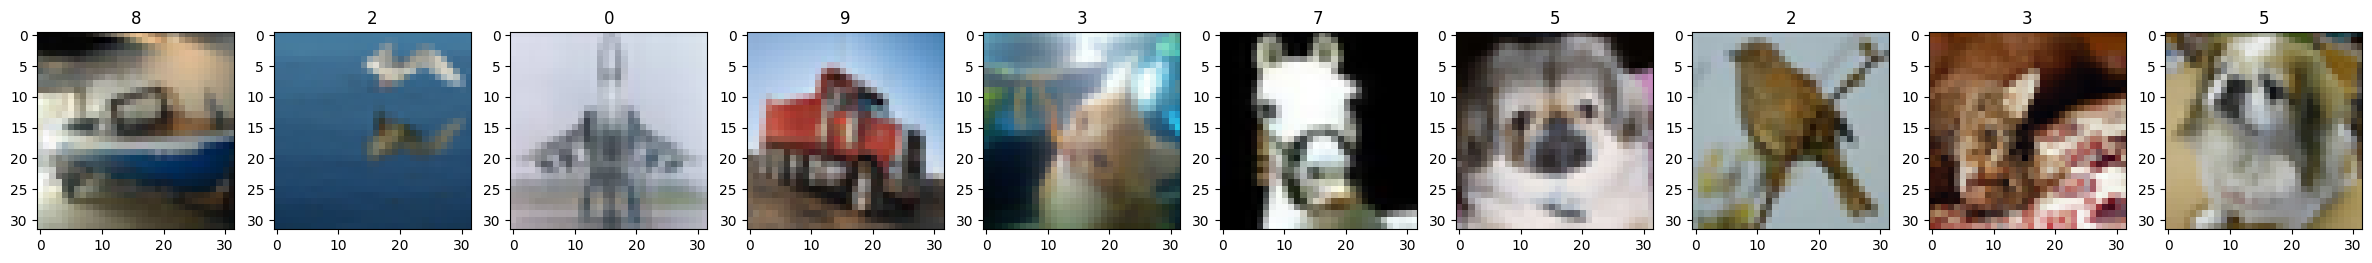

In [ ]:
# функция отрисовки картинок
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# получаем батч картинок
for batch in train_loader:
    images, labels = batch
    break

show_images(images, labels)

### Построение модели

Ниже — ячейка для построения модели. Не стоит сразу делать большую и сложную модель с большим количеством слоев: такая сеть будет обучаться очень долго и, скорее всего, переобучится.

Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 60% accuracy.

__Внимание: ваша модель должна быть представлена именно переменной `model`.__

Идеи, что можно попробовать, чтобы улучшить результат сети:

- попробовать разное количество сверточных и полносвязных слоев;
- попробовать разное количество фильтров в сверточных слоях;
- попробовать разное количество нейронов в скрытых полносвязных слоях;
- попробовать добавить BatchNorm, как после полносвязных, так и после сверточных слоев. Обратите внимание, что для сверточных слоев используется [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Аргумент num_features равен количеству фильтров (out_channels) сверточного слоя;
- попробовать добавить/убрать max_pooling;
- поменять learning_rate;
- обучать сеть большее количество эпох.

Если ваша модель переобучается (метрика на валидации нацинает становиться хуже), попробуйте уменьшить количество параметров модели. Если модель не переобучается, но показывает плохой результат, попробуйте увеличить количество параметров модели.

In [ ]:
# ВАШ КОД ЗДЕСЬ
# объявите класс сверточной нейросети

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5)) #28*28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #14*14
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) #12*12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) #6*6
        #self.conv3 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=(3,3)) #4*4
        #self.pool3 = nn.MaxPool2d(kernel_size=(2,2)) #2*2
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6*6*9, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #x = F.relu(self.conv3(x))
        #x = self.pool3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
model = ConvNet()

Ячейка ниже проверяет, доступен ли GPU и если да, то переносит нейросеть на GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Обучение модели

Функция обучения сети (ее менять не нужно).

Функция выводит текущие значения лосса и accuracy на train выборке каждые 50 итераций обучения. Также после каждой эпохи считается и выводится лосс и accuracy на val выборке. По этим значениям можно понимать, как хорошо обучается ваша модель.

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 100 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

Запускаем обучение.

In [ ]:
# снова объявим модель
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
#learning_rate = 1e-3
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, loss_fn, optimizer, n_epoch=10)

Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 2.0316411411762236 0.23015624
Средние train лосс и accuracy на последних 50 итерациях: 1.8687303847074508 0.296875
Средние train лосс и accuracy на последних 50 итерациях: 1.7773267030715942 0.33401042
Средние train лосс и accuracy на последних 50 итерациях: 1.716554498076439 0.36078125
Средние train лосс и accuracy на последних 50 итерациях: 1.6704358794689178 0.38021874
Средние train лосс и accuracy на последних 50 итерациях: 1.6333683123191198 0.39622396
Эпоха 1/10: val лосс и accuracy: 1.439254366288519 0.4832
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 1.3946746468544007 0.49640626
Средние train лосс и accuracy на последних 50 итерациях: 1.3681502109766006 0.5088281
Средние train лосс и accuracy на последних 50 итерациях: 1.3568862724304198 0.51151043
Средние train лосс и accuracy на последних 50 итерациях: 1.3489337182044983 0.51285154
Средние train лосс и accuracy на последних 50 итерациях: 1

### Получение метрики качества на тестовой выборке

In [ ]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.6021


Вы можете экспериментировать с разным устройством архитектуры нейросети и запускать ее обучение и проверять accuracy на тесте с помощью трех ячеек выше. Когда вы получили нужное значение accuracy на тесте, можете сдавать задание на Я.Контест.

Проверка, что необходимые пороги пройдены:

In [ ]:
if test_accuracy <= 0.5:
    print("Качество на тесте ниже 0.5, 0 баллов")
elif test_accuracy < 0.6:
    print("Качество на тесте между 0.5 и 0.6, 0.5 баллов")
elif test_accuracy >= 0.6:
    print("Качество на тесте выше 0.6, 1 балл")

Качество на тесте выше 0.6, 1 балл


### Сдача задания
В ячейке ниже реализован код для получения файла с обученной сетью. Запустите эти ячейки. Полученный файл model.pth отправьте в Я.Контест

In [ ]:
model.eval()
x = torch.randn((1, 3, 32, 32))
torch.jit.save(torch.jit.trace(model.cpu(), (x)), "model.pth")

Теперь у вас во вкладке "файлы" лежит файл model.pth. Загрузите этот файл в Я.Контест. И на этом задание завершено. Поздравляем!